In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
%%capture
! pip install pytdc

In [4]:
import safe as sf
import datamol as dm
from safe.trainer.data_utils import get_dataset
from safe import SAFEDesign

In [5]:
designer = SAFEDesign.load_default(verbose=True)

In [6]:
from tdc import Evaluator
diversity_evaluator = Evaluator(name = 'Diversity')
validity_evaluator = Evaluator(name = 'Validity')
uniqueness_evaluator = Evaluator(name = 'Uniqueness')

In [7]:
N_SAMPLES = 1000
N_TRIALS = 10

## De novo generation

Generation of novel molecules without any constraints.

In [10]:
generated = designer.de_novo_generation(sanitize=False, n_samples_per_trial=N_SAMPLES, n_trials=N_TRIALS, how='random', max_length=150)

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
# replace None by empty string
final_generated = [x if x is not None else '' for x in generated]

In [23]:
import pandas as pd
df = pd.DataFrame({'SMILES': final_generated})
def _sas(x):
    try:
        return dm.descriptors.sas(x)
    except:
        return None
with dm.without_rdkit_log():
    df["MOL"] = df["SMILES"].apply(dm.to_mol)
    df["clogp"] = df["MOL"].apply(dm.descriptors.clogp)
    df["qed"] = df["MOL"].apply(dm.descriptors.qed)
    df["sas"] = df["MOL"].apply(_sas)
    df["mw"] = df["MOL"].apply(dm.descriptors.mw)
df.drop(columns=["MOL"]).to_csv("10k_generated.csv", index=False)

In [64]:
import seaborn as sns
sns.set(context='notebook', font_scale=1.2)

<Axes: xlabel='clogp', ylabel='Percent'>

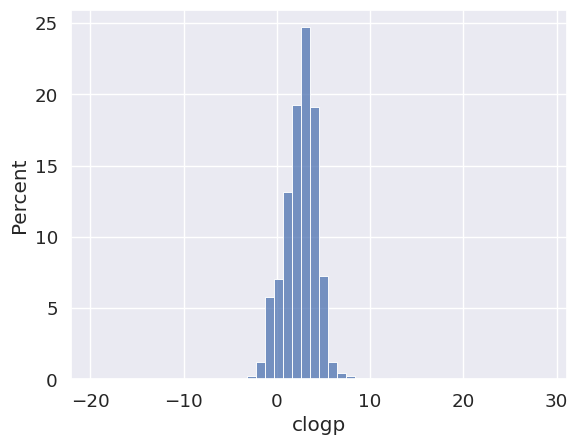

In [65]:
sns.histplot(df.dropna(axis=0)["clogp"], stat="percent", discrete=False, bins=50)

<Axes: xlabel='qed', ylabel='Percent'>

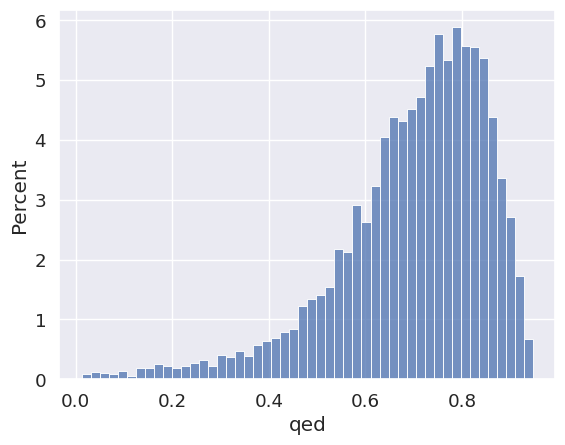

In [66]:
sns.histplot(df.dropna(axis=0)["qed"], stat="percent", discrete=False, bins=50)

<Axes: xlabel='sas', ylabel='Percent'>

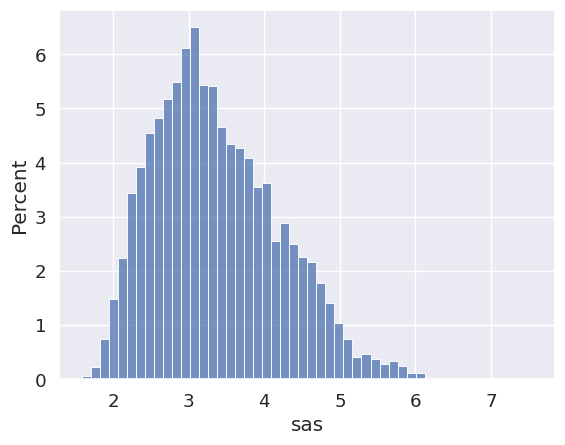

In [67]:
sns.histplot(df.dropna(axis=0)["sas"],  stat="percent", discrete=False, bins=50)

<Axes: xlabel='mw', ylabel='Percent'>

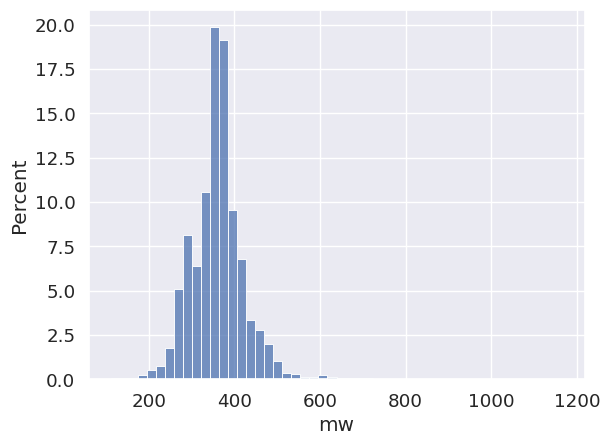

In [68]:
sns.histplot(df.dropna(axis=0)["mw"],  stat="percent", discrete=False, bins=50)

In [69]:
results = {}
results["validity@10k"] = validity_evaluator(final_generated)
results["uniqueness@10k"] = uniqueness_evaluator(final_generated)
results["diversity@10k"] = diversity_evaluator(final_generated)
results["validity@1k"] = validity_evaluator(final_generated[:1000])
results["uniqueness@1k"] = uniqueness_evaluator(final_generated[:1000])
results["diversity@1k"] = diversity_evaluator(final_generated[:1000])

[00:06:36] WARNING: not removing hydrogen atom without neighbors
[00:06:37] WARNING: not removing hydrogen atom without neighbors
[00:06:37] WARNING: not removing hydrogen atom without neighbors
[00:06:38] WARNING: not removing hydrogen atom without neighbors
[00:06:38] WARNING: not removing hydrogen atom without neighbors
[00:06:38] WARNING: not removing hydrogen atom without neighbors
[00:06:39] WARNING: not removing hydrogen atom without neighbors
[00:06:40] WARNING: not removing hydrogen atom without neighbors
[00:06:40] WARNING: not removing hydrogen atom without neighbors
[00:06:41] WARNING: not removing hydrogen atom without neighbors
[00:06:41] WARNING: not removing hydrogen atom without neighbors
[00:06:41] WARNING: not removing hydrogen atom without neighbors


In [70]:
results

{'validity@10k': 0.8431,
 'uniqueness@10k': 0.8432,
 'diversity@10k': 0.8752260349844018,
 'validity@1k': 0.841,
 'uniqueness@1k': 0.842,
 'diversity@1k': 0.8741752789100089}